In [8]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [9]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2022-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 2531 candles for ETHUSDT


In [10]:
# -- Indicator variable --
trixLength = 9
trixSignal = 19
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow, smooth1=3, smooth2=3)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2022-01-01 00:00:00,3676.22,3730.00,3676.22,3723.04,9023.3740,NaN,NaN,NaN,NaN,NaN
2022-01-01 01:00:00,3723.04,3748.45,3714.10,3724.89,8997.7569,NaN,NaN,NaN,NaN,NaN
2022-01-01 02:00:00,3724.88,3738.47,3722.23,3728.32,5028.4531,NaN,NaN,NaN,NaN,NaN
2022-01-01 03:00:00,3728.41,3737.00,3721.84,3723.96,3543.1853,NaN,NaN,NaN,NaN,NaN
2022-01-01 04:00:00,3723.96,3728.07,3707.24,3708.21,6117.2820,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-16 06:00:00,3041.77,3041.77,3035.29,3037.74,2878.6745,3032.397221,0.027433,0.002524,0.024909,0.529070
2022-04-16 07:00:00,3037.74,3040.80,3033.27,3034.64,4736.4564,3033.151591,0.024877,0.004797,0.020080,0.320387
2022-04-16 08:00:00,3034.64,3041.84,3027.71,3034.96,8344.5053,3033.802405,0.021457,0.007068,0.014389,0.343369


In [11]:
# -- Intern parameter --
dfTest = df['2017-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if row['TRIX_HISTO'] < 0:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']
        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 949.873343060761


In [12]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2022-01-01 00:00:00] -> [2022-04-16 10:00:00]
Starting balance : 999.3000000000001 $

----- General Informations -----
Final balance : 949.87 $
Performance vs US Dollar : -4.95 %
Buy and Hold Performence : -18.31 %
Performance vs Buy and Hold : 16.37 %
Best trade : +14.21 %, the 2022-02-05 03:00:00
Worst trade : -7.22 %, the 2022-01-21 23:00:00
Worst drawDown : - 27.74 %
Total fees :  84.43 $

----- Trades Informations -----
Total trades on period : 67
Number of positive trades : 28
Number of negative trades :  39
Trades win rate ratio : 41.79 %
Average trades performance : 0.07 %
Average positive trades : 3.31 %
Average negative trades : -2.26 %

----- Time Informations -----
Average time duration for a trade : 15.39 periods
Maximum time duration for a trade : 33 periods
Minimum time duration for a trade : 2 periods
Average time duration between two trades : 21.65 periods
Maximum time duration between two trades : 74 periods
Minimum ti

----- 2022 Performances: -4.95% -----


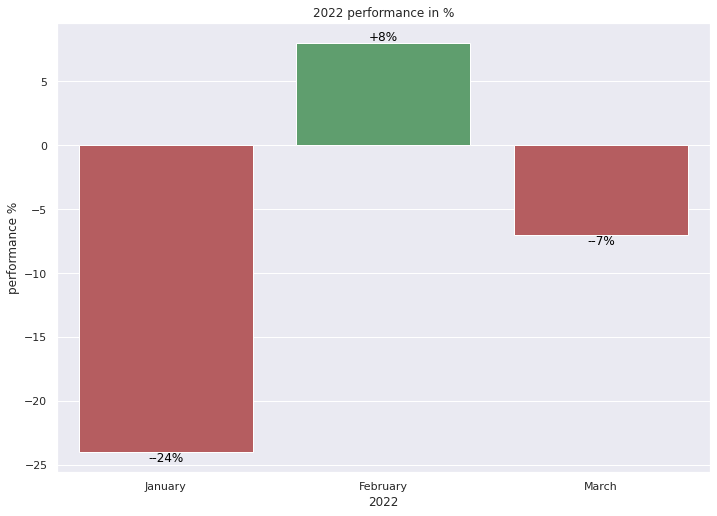

In [13]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


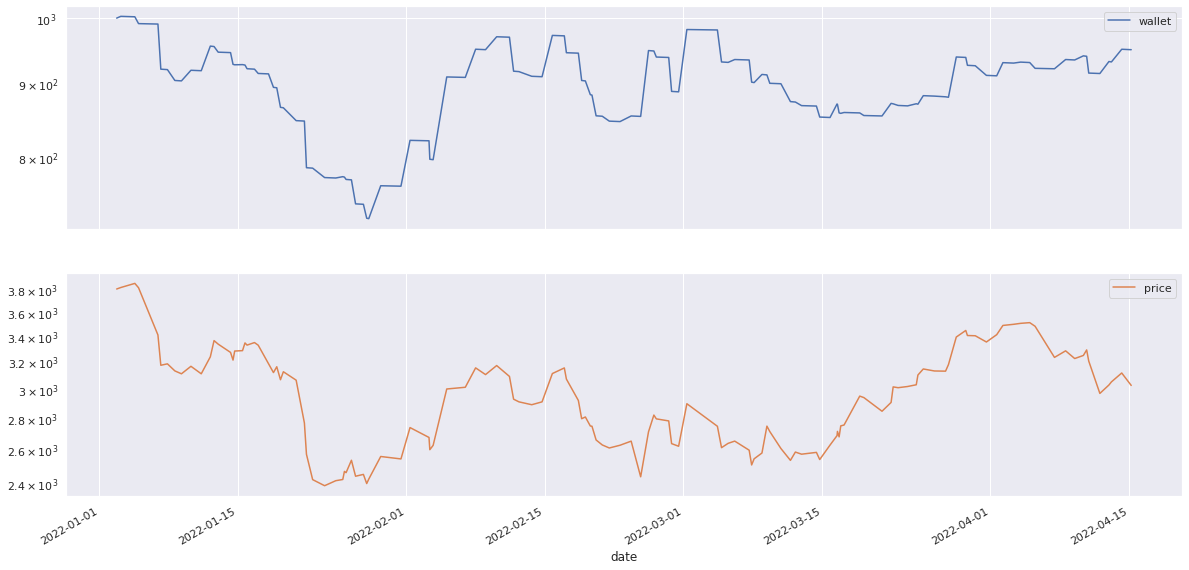

In [14]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)